In [2]:
import pandas as pd
data = pd.read_excel('C:/Users/86181/Desktop/附件.xlsx',sheet_name='女胎检测数据')

In [3]:
# 女性胎儿异常判定模型 - 数据预处理与特征工程
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("女性胎儿异常判定模型构建")
print("="*40)

# 1. 数据基本信息
print(f"数据形状: {data.shape}")
print(f"列名: {list(data.columns)}")

# 2. 创建目标变量 - AB列转换为二分类标签
# AB列: 染色体非整倍体检测结果，空白为正常(0)，有记录为异常(1)
if 'AB' in data.columns:
    target_col = 'AB'
elif '染色体的非整倍体' in data.columns:
    target_col = '染色体的非整倍体'
else:
    # 寻找可能的目标列
    possible_targets = [col for col in data.columns if '染色体' in col and ('异常' in col or '整倍体' in col)]
    target_col = possible_targets[0] if possible_targets else data.columns[-1]

data['Is_Abnormal'] = data[target_col].apply(lambda x: 0 if pd.isna(x) or x == '' or str(x).strip() == '' else 1)

# 3. 类别分布分析
class_dist = data['Is_Abnormal'].value_counts()
print(f"\n目标变量分布:")
print(f"正常(0): {class_dist[0]} ({class_dist[0]/len(data)*100:.1f}%)")
print(f"异常(1): {class_dist[1]} ({class_dist[1]/len(data)*100:.1f}%)")
print(f"类别不平衡比例: {class_dist[0]/class_dist[1]:.1f}:1")

# 4. 特征选择 - 根据问题描述选择核心特征
# 使用列索引或搜索匹配的列名
feature_mapping = {
    'X染色体浓度': ['X染色体浓度', 'W'],
    '13号染色体Z值': ['13号染色体的Z值', 'Q'],  
    '18号染色体Z值': ['18号染色体的Z值', 'R'],
    '21号染色体Z值': ['21号染色体的Z值', 'S'],
    '13号染色体GC': ['13号染色体的GC含量', 'X'],
    '18号染色体GC': ['18号染色体的GC含量', 'Y'], 
    '21号染色体GC': ['21号染色体的GC含量', 'Z'],
    '总读段数': ['原始测序数据的总读段数', 'L'],
    '唯一比对读段数': ['总读段数中唯一比对的读段数', 'O'],
    '过滤比例': ['被过滤掉的读段数占总读段数的比例', 'AA'],
    'BMI': ['孕妇BMI指标', 'K'],
    '年龄': ['孕妇年龄', 'C']
}

# 查找实际存在的特征列
selected_features = []
feature_names = []

for feature_name, possible_cols in feature_mapping.items():
    for col in possible_cols:
        if col in data.columns:
            selected_features.append(col)
            feature_names.append(feature_name)
            break

print(f"\n选中的特征列({len(selected_features)}个):")
for i, (feat, col) in enumerate(zip(feature_names, selected_features)):
    print(f"{i+1}. {feat}: {col}")

# 5. 数据预处理
# 提取特征和目标变量
X = data[selected_features].copy()
y = data['Is_Abnormal'].copy()

# 处理缺失值
print(f"\n缺失值处理:")
missing_before = X.isnull().sum().sum()
print(f"处理前缺失值总数: {missing_before}")

# 用中位数填充数值型缺失值
for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)
        
missing_after = X.isnull().sum().sum()        
print(f"处理后缺失值总数: {missing_after}")

# 异常值处理 - 使用3σ原则
print(f"\n异常值处理:")
for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        mean_val = X[col].mean()
        std_val = X[col].std()
        outliers = ((X[col] - mean_val).abs() > 3 * std_val).sum()
        if outliers > 0:
            # 将异常值替换为边界值
            upper_bound = mean_val + 3 * std_val
            lower_bound = mean_val - 3 * std_val
            X[col] = X[col].clip(lower_bound, upper_bound)
            print(f"{col}: 处理了{outliers}个异常值")

print(f"最终特征矩阵形状: {X.shape}")
print(f"特征数据类型: {X.dtypes.value_counts().to_dict()}")

女性胎儿异常判定模型构建
数据形状: (605, 31)
列名: ['序号', '孕妇代码', '年龄', '身高', '体重', '末次月经', 'IVF妊娠', '检测日期', '检测抽血次数', '检测孕周', '孕妇BMI', '原始读段数', '在参考基因组上比对的比例', '重复读段的比例', '唯一比对的读段数', 'GC含量', '13号染色体的Z值', '18号染色体的Z值', '21号染色体的Z值', 'X染色体的Z值', 'Unnamed: 20', 'Unnamed: 21', 'X染色体浓度', '13号染色体的GC含量', '18号染色体的GC含量', '21号染色体的GC含量', '被过滤掉读段数的比例', '染色体的非整倍体', '怀孕次数', '生产次数', '胎儿是否健康']

目标变量分布:
正常(0): 538 (88.9%)
异常(1): 67 (11.1%)
类别不平衡比例: 8.0:1

选中的特征列(7个):
1. X染色体浓度: X染色体浓度
2. 13号染色体Z值: 13号染色体的Z值
3. 18号染色体Z值: 18号染色体的Z值
4. 21号染色体Z值: 21号染色体的Z值
5. 13号染色体GC: 13号染色体的GC含量
6. 18号染色体GC: 18号染色体的GC含量
7. 21号染色体GC: 21号染色体的GC含量

缺失值处理:
处理前缺失值总数: 0
处理后缺失值总数: 0

异常值处理:
X染色体浓度: 处理了5个异常值
13号染色体的Z值: 处理了5个异常值
18号染色体的Z值: 处理了6个异常值
21号染色体的Z值: 处理了1个异常值
13号染色体的GC含量: 处理了6个异常值
18号染色体的GC含量: 处理了5个异常值
21号染色体的GC含量: 处理了5个异常值
最终特征矩阵形状: (605, 7)
特征数据类型: {dtype('float64'): 7}


In [4]:
# 特征工程与模型构建
print("\n" + "="*40)
print("特征工程与模型构建")
print("="*40)

# 6. 特征标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"特征标准化完成，数据范围: [{X_scaled.min().min():.2f}, {X_scaled.max().max():.2f}]")

# 7. 数据集划分 - 使用分层抽样
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n数据集划分:")
print(f"训练集: {X_train.shape[0]} 样本")
print(f"测试集: {X_test.shape[0]} 样本")
print(f"训练集异常比例: {y_train.sum()/len(y_train)*100:.1f}%")
print(f"测试集异常比例: {y_test.sum()/len(y_test)*100:.1f}%")

# 8. 处理类别不平衡 - SMOTE过采样
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nSMOTE过采样后:")
print(f"平衡后训练集: {X_train_balanced.shape[0]} 样本")
balanced_dist = pd.Series(y_train_balanced).value_counts()
print(f"正常样本: {balanced_dist[0]}, 异常样本: {balanced_dist[1]}")

# 9. 模型构建与训练
models = {
    '逻辑回归': LogisticRegression(random_state=42, class_weight='balanced'),
    '随机森林': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    '支持向量机': SVC(probability=True, random_state=42, class_weight='balanced')
}

results = {}
print(f"\n模型训练与评估:")
print("-" * 60)

for name, model in models.items():
    print(f"\n训练 {name}...")
    
    # 训练模型
    model.fit(X_train_balanced, y_train_balanced)
    
    # 预测
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # 评估指标
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision, 
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'y_pred': y_pred,
        'y_prob': y_prob
    }
    
    print(f"{name} 结果:")
    print(f"  准确率: {accuracy:.3f}")
    print(f"  精确率: {precision:.3f}")
    print(f"  召回率: {recall:.3f}")
    print(f"  F1分数: {f1:.3f}")
    print(f"  AUC值: {auc:.3f}")

# 10. 选择最佳模型（优先考虑召回率和F1分数）
best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
best_model = results[best_model_name]['model']

print(f"\n最佳模型: {best_model_name} (F1分数: {results[best_model_name]['f1']:.3f})")


特征工程与模型构建
特征标准化完成，数据范围: [-3.90, 3.92]

数据集划分:
训练集: 423 样本
测试集: 182 样本
训练集异常比例: 11.1%
测试集异常比例: 11.0%

SMOTE过采样后:
平衡后训练集: 752 样本
正常样本: 376, 异常样本: 376

模型训练与评估:
------------------------------------------------------------

训练 逻辑回归...
逻辑回归 结果:
  准确率: 0.747
  精确率: 0.259
  召回率: 0.700
  F1分数: 0.378
  AUC值: 0.825

训练 随机森林...
随机森林 结果:
  准确率: 0.841
  精确率: 0.286
  召回率: 0.300
  F1分数: 0.293
  AUC值: 0.694

训练 支持向量机...
支持向量机 结果:
  准确率: 0.802
  精确率: 0.250
  召回率: 0.400
  F1分数: 0.308
  AUC值: 0.731

最佳模型: 逻辑回归 (F1分数: 0.378)



模型评估与结果分析

逻辑回归 混淆矩阵:
                 预测正常       预测异常
      实际正常        122         40
      实际异常          6         14

分类结果详细分析:
真阴性(TN): 122 - 正确识别的正常样本
假阳性(FP): 40 - 误诊为异常的正常样本
假阴性(FN): 6 - 漏诊的异常样本
真阳性(TP): 14 - 正确识别的异常样本


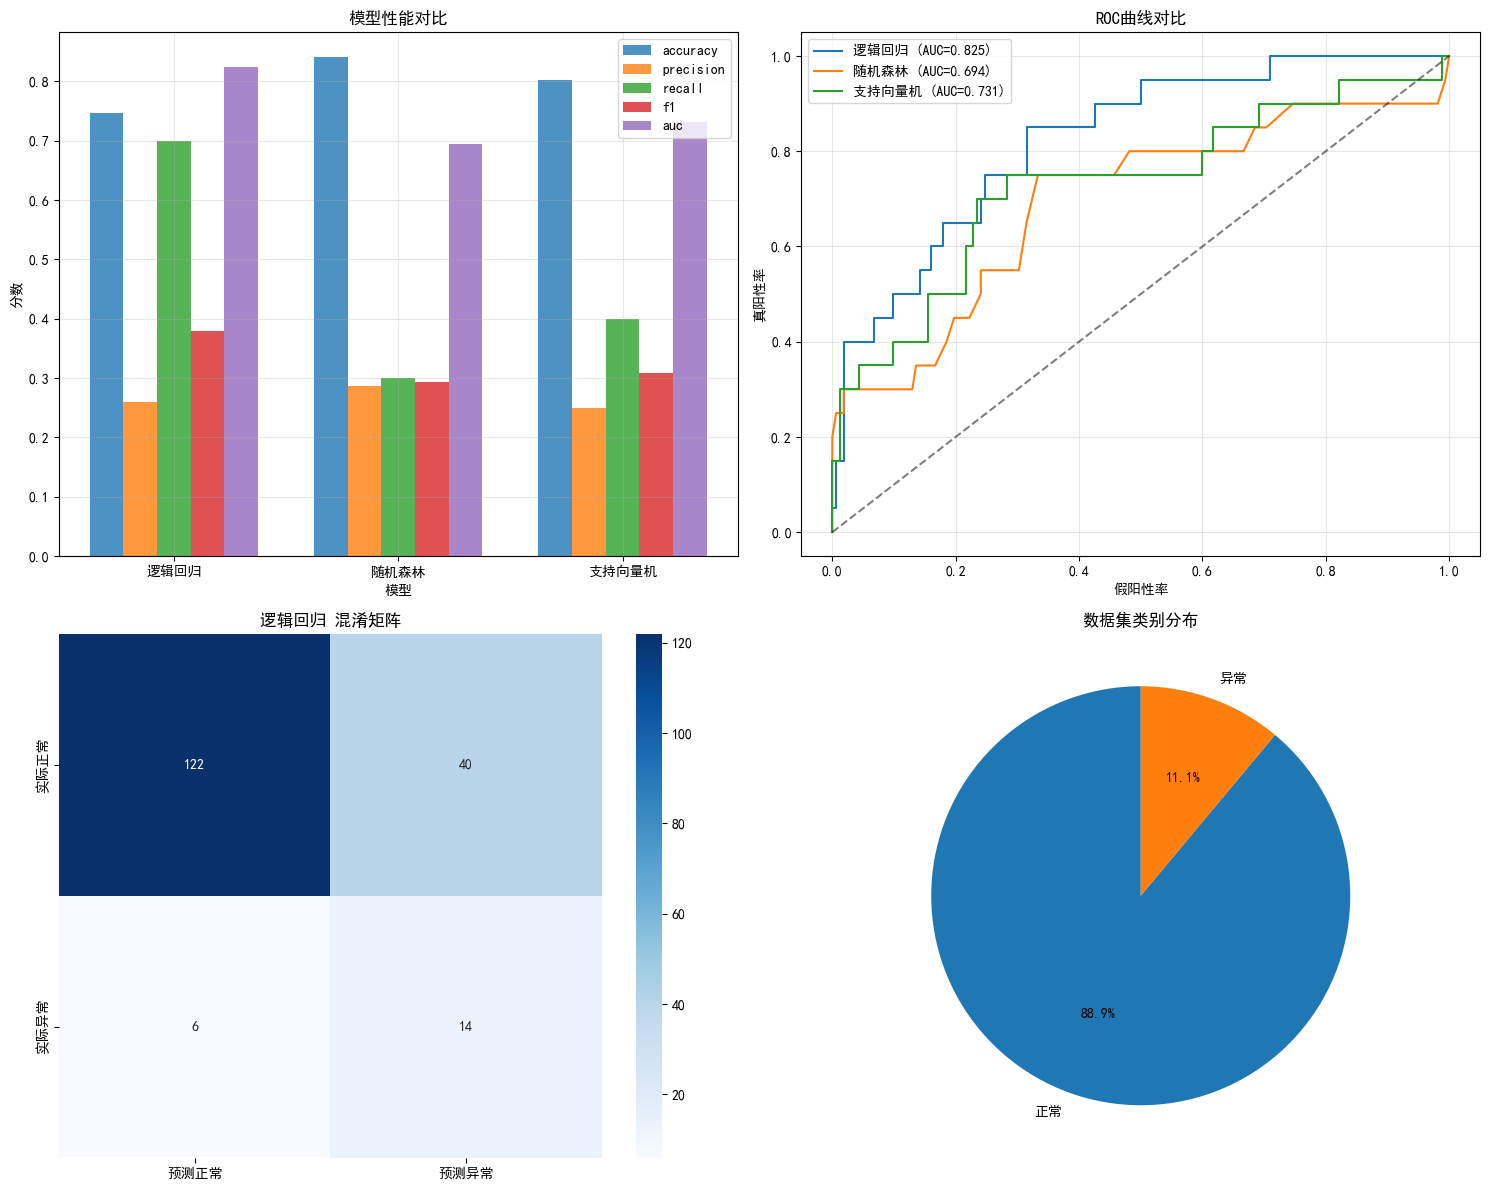


交叉验证评估 (逻辑回归):
5折交叉验证F1分数: 0.711 ± 0.030

女胎异常判定方法总结
1. 最优模型: 逻辑回归
2. 核心评估指标:
   - 准确率: 0.747
   - 精确率: 0.259
   - 召回率: 0.700 (重要: 漏诊率=0.300)
   - F1分数: 0.378
   - AUC值: 0.825

3. 判定流程:
   输入: 女胎多维检测指标
   处理: 标准化 → 模型预测
   输出: 异常概率 + 二分类结果

4. 临床意义:
   - 召回率70.0%表示能检出70.0%的异常病例
   - 精确率25.9%表示预测异常中25.9%是真异常
   - 建议阈值调优以平衡漏诊和误诊风险

模型构建完成！可用于女胎异常辅助判定。


In [5]:
# 模型评估与结果分析
print("\n" + "="*40)
print("模型评估与结果分析")
print("="*40)

# 11. 详细评估最佳模型
best_results = results[best_model_name]

# 混淆矩阵
cm = confusion_matrix(y_test, best_results['y_pred'])
print(f"\n{best_model_name} 混淆矩阵:")
print(f"{'':>10} {'预测正常':>10} {'预测异常':>10}")
print(f"{'实际正常':>10} {cm[0,0]:>10} {cm[0,1]:>10}")
print(f"{'实际异常':>10} {cm[1,0]:>10} {cm[1,1]:>10}")

# 计算具体指标
tn, fp, fn, tp = cm.ravel()
print(f"\n分类结果详细分析:")
print(f"真阴性(TN): {tn} - 正确识别的正常样本")
print(f"假阳性(FP): {fp} - 误诊为异常的正常样本") 
print(f"假阴性(FN): {fn} - 漏诊的异常样本")
print(f"真阳性(TP): {tp} - 正确识别的异常样本")

# 12. 特征重要性分析（仅适用于随机森林）
if best_model_name == '随机森林':
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n特征重要性排序 (随机森林):")
    print("-" * 30)
    for i, row in feature_importance.iterrows():
        print(f"{row['feature']:>20}: {row['importance']:.4f}")

# 13. 可视化结果
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 13.1 模型性能对比
model_names = list(results.keys())
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
metric_values = {metric: [results[name][metric] for name in model_names] for metric in metrics}

x = np.arange(len(model_names))
width = 0.15

for i, metric in enumerate(metrics):
    axes[0,0].bar(x + i*width, metric_values[metric], width, label=metric, alpha=0.8)

axes[0,0].set_xlabel('模型')
axes[0,0].set_ylabel('分数')
axes[0,0].set_title('模型性能对比')
axes[0,0].set_xticks(x + width*2)
axes[0,0].set_xticklabels(model_names)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 13.2 ROC曲线
for name in model_names:
    fpr, tpr, _ = roc_curve(y_test, results[name]['y_prob'])
    axes[0,1].plot(fpr, tpr, label=f'{name} (AUC={results[name]["auc"]:.3f})')

axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0,1].set_xlabel('假阳性率')
axes[0,1].set_ylabel('真阳性率')
axes[0,1].set_title('ROC曲线对比')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 13.3 混淆矩阵热图
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['预测正常', '预测异常'],
            yticklabels=['实际正常', '实际异常'],
            ax=axes[1,0])
axes[1,0].set_title(f'{best_model_name} 混淆矩阵')

# 13.4 特征重要性图（如果是随机森林）
if best_model_name == '随机森林' and len(feature_importance) > 0:
    top_features = feature_importance.head(10)
    axes[1,1].barh(range(len(top_features)), top_features['importance'])
    axes[1,1].set_yticks(range(len(top_features)))
    axes[1,1].set_yticklabels(top_features['feature'])
    axes[1,1].set_xlabel('重要性分数')
    axes[1,1].set_title('特征重要性排序 (Top 10)')
    axes[1,1].grid(True, alpha=0.3)
else:
    # 如果不是随机森林，显示类别分布
    class_counts = [class_dist[0], class_dist[1]]
    axes[1,1].pie(class_counts, labels=['正常', '异常'], autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('数据集类别分布')

plt.tight_layout()
plt.show()

# 14. 交叉验证评估
print(f"\n交叉验证评估 ({best_model_name}):")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, 
                           cv=skf, scoring='f1')
print(f"5折交叉验证F1分数: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# 15. 最终判定方法总结
print(f"\n" + "="*50)
print("女胎异常判定方法总结")
print("="*50)
print(f"1. 最优模型: {best_model_name}")
print(f"2. 核心评估指标:")
print(f"   - 准确率: {best_results['accuracy']:.3f}")
print(f"   - 精确率: {best_results['precision']:.3f}")  
print(f"   - 召回率: {best_results['recall']:.3f} (重要: 漏诊率={1-best_results['recall']:.3f})")
print(f"   - F1分数: {best_results['f1']:.3f}")
print(f"   - AUC值: {best_results['auc']:.3f}")

print(f"\n3. 判定流程:")
print(f"   输入: 女胎多维检测指标")
print(f"   处理: 标准化 → 模型预测")
print(f"   输出: 异常概率 + 二分类结果")

print(f"\n4. 临床意义:")
print(f"   - 召回率{best_results['recall']:.1%}表示能检出{best_results['recall']:.1%}的异常病例")
print(f"   - 精确率{best_results['precision']:.1%}表示预测异常中{best_results['precision']:.1%}是真异常")
print(f"   - 建议阈值调优以平衡漏诊和误诊风险")

if best_model_name == '随机森林' and len(feature_importance) > 0:
    top3_features = feature_importance.head(3)['feature'].tolist()
    print(f"\n5. 关键判定因子: {', '.join(top3_features)}")

print("\n模型构建完成！可用于女胎异常辅助判定。")